# TP 4: Improve the Metropolis-Hastings algorithm

In [1]:
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as mcol
import matplotlib.cm as cm
from scipy.stats import invgamma, multivariate_normal, Covariance

DEFAULT_ITERATIONS = 100

## Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

Here are a few useful functions that we will use to plot our results.

In [2]:
def plot_density(pi, xmin=-10, xmax=10, ymin=-2, ymax=2, n=100, ax=None):
    x = np.linspace(xmin, xmax, n)
    y = np.linspace(ymin, ymax, n)

    X, Y = np.meshgrid(x, y)
    Z = pi(np.array([X, Y]))
    if ax is not None:
        ax.contour(X, Y, Z, cmap="viridis")
    else:
        plt.contour(X, Y, Z, cmap="viridis")


def plot_adaptative_gibbs(
    z_chain,
    acceptances,
    log_pi,
    plots=["trajectory", "density", "acceptance", "autocorrelation"],
):
    nb_plots = len(plots)
    if "density" in plots and "trajectory" in plots:
        nb_plots -= 1

    fig, ax = plt.subplots(1, nb_plots, figsize=(7 * nb_plots, 7))
    plot = 0

    if "trajectory" in plots:
        scatter = ax[plot].scatter(
            z_chain[:, 0],
            z_chain[:, 1],
            c=np.arange(len(z_chain)),
            cmap="Reds",
            s=1,
            alpha=0.6,
        )
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes("right", size="5%", pad=0)
        fig.colorbar(scatter, ax=ax[plot], cax=cax, label="Iteration")
        ax[plot].set_title("Chain trajectory")
        plt.subplots_adjust(wspace=0.3)

    if "density" in plots:
        plot_density(lambda z: np.exp(log_pi(z)), xmin=-20, xmax=20, ax=ax[plot])
        ax[plot].set_title("Target density")

    if "trajectory" in plots or "density" in plots:
        ax[plot].set_xlabel("x")
        ax[plot].set_ylabel("y")
        ax[plot].set_title("Chain trajectory and target density")
        plot += 1

    if "acceptance" in plots:
        averaged_acceptances = (
            np.cumsum(acceptances, axis=0) / np.arange(1, len(acceptances) + 1)[:, None]
        )

        for i in range(z_chain.shape[1]):
            ax[plot].plot(averaged_acceptances[:, i], label=f"x_{i}")

        ax[plot].set_xlabel("Number of updates")
        ax[plot].set_ylabel("Acceptance rate")
        ax[plot].set_ylim(0, 1)
        ax[plot].hlines(
            0.24,
            0,
            len(averaged_acceptances),
            label="Target",
            linestyles="dashed",
        )
        ax[plot].legend()
        ax[plot].set_title("Acceptance rate evolution")
        plot += 1

    if "autocorrelation" in plots:
        for i in range(z_chain.shape[1]):
            autocorrelation = acf(z_chain[:, i], nlags=len(z_chain))
            ax[plot].plot(autocorrelation, label=f"Corr(x_{i}, x_{i})", linewidth=1)

        ax[plot].set_xscale("log")
        ax[plot].set_xlabel("Lag")
        ax[plot].set_ylabel("Autocorrelation")
        ax[plot].legend()
        ax[plot].set_title("Coordinates autocorrelation")
        plot += 1

    plt.show()

### 1.A – Metropolis-Hastings within Gibbs sampler

#### Question 1.

In [3]:
def symetric_random_walk_metropolis_hastings(
    x0, y0, log_pi, sigma_x=3, sigma_y=3, iter=DEFAULT_ITERATIONS
):
    x_chain = [x0]
    y_chain = [y0]

    for _ in range(iter):
        x = x_chain[-1]
        y = y_chain[-1]

        # The transition kernel here is 1/2 P_1 + 1/2 P_2. We randomly chose between P_1 and P_2
        u = np.random.uniform()
        if u > 1 / 2:
            proposal_x = x + np.random.normal(0, sigma_x)
            proposal_y = y
        else:
            proposal_x = x
            proposal_y = y + np.random.normal(0, sigma_y)

        log_alpha = min(0, log_pi([proposal_x, proposal_y]) - log_pi([x, y]))

        if np.log(np.random.uniform()) < log_alpha:
            x_chain.append(proposal_x)
            y_chain.append(proposal_y)
        else:
            x_chain.append(x)
            y_chain.append(y)

    return x_chain, y_chain

#### Question 2.

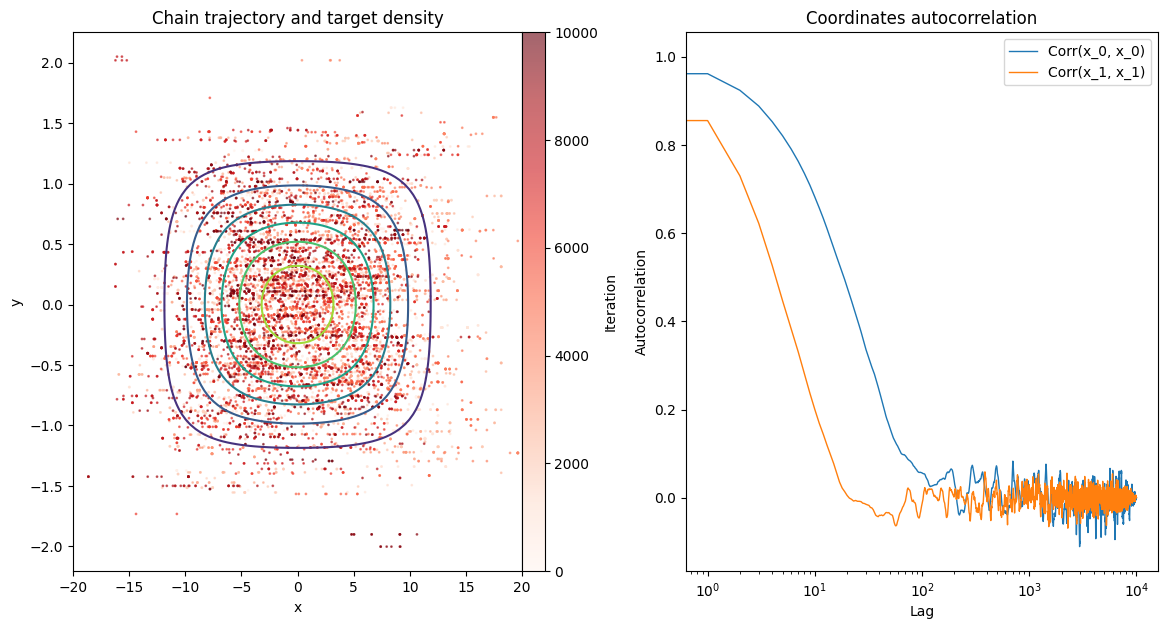

In [4]:
def log_pi(z, a=10):
    x, y = z[0], z[1]
    return -(x**2) / a**2 - y**2 - 1 / 4 * (x**2 / a**2 - y**2) ** 2


x_chain, y_chain = symetric_random_walk_metropolis_hastings(
    0, 0, log_pi, sigma_x=3, sigma_y=3, iter=10000
)

plot_adaptative_gibbs(
    np.array([x_chain, y_chain]).T,
    None,
    log_pi,
    plots=["trajectory", "density", "autocorrelation"],
)

The distribution is anisotropic, so having the same proposal distribution for all directions is probably not optimal. In practice we see on the trajectory that the chain will have no problem to explore the $x$ direction, because a variance of 3 is well adapted to the target distribution in this direction. However the chain will rarely accept a move in the $y$ direction, because a variance of 3 is too big compared to the target distribution in this direction. The resulting trajectory show horizontal lines where the chain is stuck in the same $y$.

#### Question 3.
* One solution is to use different variances for the proposal distribution in each direction. For instance a variance of 3 in the $x$ direction and a variance of 0.5 in the $y$ direction should yield better results.
* Another solution is to use adaptative metropolis-hastings : the parameters of the proposal distribution are tuned during the simulation to reach a target acceptance rate.

### 1.B – Adaptive Metropolis-Hastings within Gibbs sampler

#### Question 1.

In [5]:
def adaptative_metropolis_hastings_within_gibbs(
    z, log_pi, iter=DEFAULT_ITERATIONS, update_every=50
):
    z_chain = np.zeros((iter, len(z)))
    d = len(z)
    l = np.zeros(d)
    acceptances = np.zeros((iter // update_every, d))
    for j in range(iter // update_every):
        for k in range(update_every):
            for i in range(d):
                proposal = np.copy(z)
                proposal[i] = np.random.normal(proposal[i], np.exp(l[i]))
                log_alpha = min(0, log_pi(proposal) - log_pi(z))
                if np.log(np.random.uniform()) < log_alpha:
                    z = proposal
                    acceptances[j, i] += 1

            z_chain[update_every * j + k] = z

        delta_j = min(
            0.1, 1 / np.sqrt(j + 1)
        )  # We took 0.1 instead of the suggested 0.01
        update_every_direction = np.sign(acceptances[j, :] / update_every - 0.24)
        l += delta_j * update_every_direction
    return z_chain, acceptances / update_every

#### Test on the density from 1.A

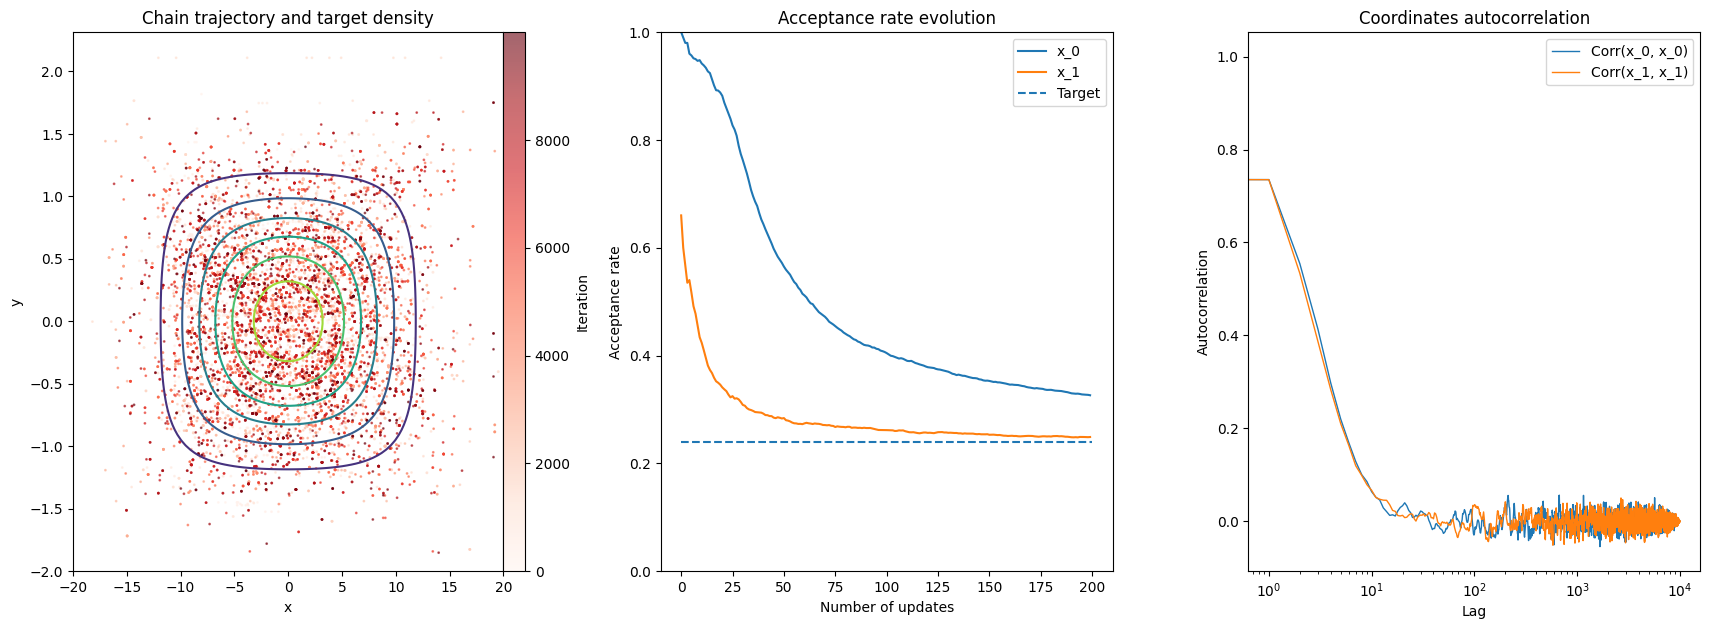

In [6]:
def log_pi(z, a=10):
    x, y = z[0], z[1]
    return -(x**2) / a**2 - y**2 - 1 / 4 * (x**2 / a**2 - y**2) ** 2


z_chain, acceptances = adaptative_metropolis_hastings_within_gibbs(
    np.random.rand(2), log_pi, iter=10000
)

plot_adaptative_gibbs(
    z_chain,
    acceptances,
    log_pi,
    plots=["trajectory", "density", "acceptance", "autocorrelation"],
)

We got rid of the horizontal lines from before. The points are now more evenly distributed in the $y$ direction. However the acceptance rates converge pretty slowly with $\delta_j=\min(0.01, j^{-1/2})$. If we take $\delta_j=\min(0.1, j^{-1/2})$ instead, the convergence is much faster. I don't really see why we would want to go with the first $\delta_j$ since in both cases $\delta_j$ converges to 0 at the same speed.

#### Question 2.

#### Test on a multivariate gaussian density

In [7]:
sigma = [
    [
        9.75686747360354,
        6.02615138919838,
        7.05063557189997,
        8.21751985243315,
        6.82041095620815,
        8.55587287347937,
        5.18063001845798,
        6.51909455014678,
        8.29677009054362,
        10.6632907391090,
        7.82992973845607,
        9.96116762628738,
        1.84850407544944,
        4.21731767250373,
        8.0029984027591,
        8.96602616834464,
        5.95119450540377,
        9.89878028064529,
        9.4728388615984,
        9.21287667038874,
    ],
    [
        6.02615138919838,
        10.5906569992946,
        10.0342258873436,
        11.2431890601171,
        6.79876105181038,
        8.63184666376993,
        6.35020851954461,
        11.7159731779928,
        9.96433055603998,
        10.1121612432404,
        11.0337999378016,
        10.8869893512022,
        7.76882609482555,
        8.83602582722582,
        9.09034665849303,
        12.5411423150661,
        9.7777638798137,
        12.6566133822919,
        12.1184400553465,
        10.6449077928942,
    ],
    [
        7.05063557189997,
        10.0342258873436,
        12.1335015181661,
        12.5740181002203,
        6.3093582418232,
        9.40288116993826,
        6.91082118397978,
        11.5940664786873,
        10.3759922477490,
        9.7986723228117,
        10.7551102708094,
        12.3625247891009,
        6.94347374149218,
        8.652484382217,
        9.25018657288943,
        13.6973151899140,
        10.1466614478431,
        13.6098016899135,
        13.1697552122813,
        11.4665708714529,
    ],
    [
        8.21751985243315,
        11.2431890601171,
        12.5740181002203,
        17.7593243970820,
        9.59007381047465,
        12.2153265846133,
        12.105339209321,
        13.3086563881315,
        12.6598559426351,
        10.2989495491691,
        13.3516859104286,
        12.4200206456721,
        10.0754009554896,
        8.32723421306367,
        8.57878148846582,
        14.8925551634749,
        14.0675465939836,
        15.6194121804455,
        13.8839225554552,
        14.5409220572441,
    ],
    [
        6.82041095620815,
        6.79876105181038,
        6.3093582418232,
        9.59007381047465,
        9.28666998094381,
        5.58508350760777,
        6.80564182868369,
        7.0446939008055,
        8.22917837813118,
        8.75753152122065,
        8.77405794674084,
        7.84686471093513,
        3.83145304778158,
        4.61171490040157,
        5.74435774940627,
        7.25033356536241,
        8.66616697012352,
        9.79633141548514,
        7.2621463326004,
        8.59869508109346,
    ],
    [
        8.55587287347937,
        8.63184666376993,
        9.40288116993826,
        12.2153265846133,
        5.58508350760777,
        14.2335850877165,
        8.75918683755554,
        11.2890075360938,
        9.76271315284105,
        11.2781989667982,
        10.3498971240041,
        11.7928584617402,
        7.19892566595828,
        5.78979640527785,
        9.72432433965226,
        13.593158251525,
        9.54739499873796,
        11.9970659491599,
        13.1554417979810,
        12.0543093105625,
    ],
    [
        5.18063001845798,
        6.35020851954461,
        6.91082118397978,
        12.105339209321,
        6.80564182868369,
        8.75918683755554,
        11.2680693155994,
        8.66965290532145,
        8.35463968876361,
        5.6173567822833,
        7.71367264650871,
        8.222950154298,
        6.78524176051197,
        2.72173193573666,
        5.26034613973575,
        8.35030052730135,
        10.1724011509190,
        10.4895839131061,
        7.78458169012829,
        9.95705122512251,
    ],
    [
        6.51909455014678,
        11.7159731779928,
        11.5940664786873,
        13.3086563881315,
        7.0446939008055,
        11.2890075360938,
        8.66965290532145,
        16.0839703652671,
        10.1130657689306,
        11.6529683851144,
        11.491079843331,
        13.7739128102936,
        10.0273808360427,
        9.35248977779265,
        11.4095324321067,
        14.6266081310762,
        11.5600323824086,
        15.7250150958461,
        15.3881171225937,
        12.3674710449843,
    ],
    [
        8.29677009054362,
        9.96433055603998,
        10.3759922477490,
        12.6598559426351,
        8.22917837813118,
        9.76271315284105,
        8.35463968876361,
        10.1130657689306,
        13.5288861911068,
        11.9964338327624,
        11.3262786690377,
        12.4057148870996,
        6.77857438215498,
        7.92253859221448,
        7.87988942295366,
        13.6973047307180,
        9.67590296141006,
        13.0830686610269,
        12.1686829426578,
        12.4323765382016,
    ],
    [
        10.6632907391090,
        10.1121612432404,
        9.7986723228117,
        10.2989495491691,
        8.75753152122065,
        11.2781989667982,
        5.6173567822833,
        11.6529683851144,
        11.9964338327624,
        18.5787498048789,
        13.5342983271543,
        13.7223702772655,
        4.78908347204804,
        8.82987988518856,
        11.0537730802420,
        13.9801209305952,
        9.8193397807449,
        14.2630612825778,
        14.7516791309607,
        11.5822106096063,
    ],
    [
        7.82992973845607,
        11.0337999378016,
        10.7551102708094,
        13.3516859104286,
        8.77405794674084,
        10.3498971240041,
        7.71367264650871,
        11.491079843331,
        11.3262786690377,
        13.5342983271543,
        15.9453111921991,
        10.2092034275105,
        7.65309878287016,
        9.3186080151754,
        9.65958008203142,
        11.6216154493776,
        12.8458186550154,
        13.5186404222116,
        12.5027983204116,
        11.2274466091158,
    ],
    [
        9.96116762628738,
        10.8869893512022,
        12.3625247891009,
        12.4200206456721,
        7.84686471093513,
        11.7928584617402,
        8.222950154298,
        13.7739128102936,
        12.4057148870996,
        13.7223702772655,
        10.2092034275105,
        17.0104054808198,
        6.30120024283854,
        8.23609778888048,
        12.2761772457396,
        16.2689394363724,
        9.99349442799766,
        16.3532591879872,
        15.8150863908131,
        13.7582029271339,
    ],
    [
        1.84850407544944,
        7.76882609482555,
        6.94347374149218,
        10.0754009554896,
        3.83145304778158,
        7.19892566595828,
        6.78524176051197,
        10.0273808360427,
        6.77857438215498,
        4.78908347204804,
        7.65309878287016,
        6.30120024283854,
        9.34999964988618,
        6.35434303590809,
        4.7689329378515,
        9.20206009754567,
        7.8779182447069,
        8.56944297413115,
        8.66801234690755,
        7.83628064129682,
    ],
    [
        4.21731767250373,
        8.83602582722582,
        8.652484382217,
        8.32723421306367,
        4.61171490040157,
        5.78979640527785,
        2.72173193573666,
        9.35248977779265,
        7.92253859221448,
        8.82987988518856,
        9.3186080151754,
        8.23609778888048,
        6.35434303590809,
        9.1479366120664,
        6.70865166804584,
        10.7987382636933,
        6.90121523999677,
        9.73670105067006,
        10.4324734902340,
        7.74131957162044,
    ],
    [
        8.0029984027591,
        9.09034665849303,
        9.25018657288943,
        8.57878148846582,
        5.74435774940627,
        9.72432433965226,
        5.26034613973575,
        11.4095324321067,
        7.87988942295366,
        11.0537730802420,
        9.65958008203142,
        12.2761772457396,
        4.7689329378515,
        6.70865166804584,
        12.3885233376586,
        10.23375866914,
        7.86615126536591,
        12.4892468048389,
        12.2084321446513,
        9.61803572982585,
    ],
    [
        8.96602616834464,
        12.5411423150661,
        13.6973151899140,
        14.8925551634749,
        7.25033356536241,
        13.593158251525,
        8.35030052730135,
        14.6266081310762,
        13.6973047307180,
        13.9801209305952,
        11.6216154493776,
        16.2689394363724,
        9.20206009754567,
        10.7987382636933,
        10.23375866914,
        23.1863075157939,
        12.6767455142431,
        17.6120953341950,
        18.1209868071631,
        16.1551846108670,
    ],
    [
        5.95119450540377,
        9.7777638798137,
        10.1466614478431,
        14.0675465939836,
        8.66616697012352,
        9.54739499873796,
        10.1724011509190,
        11.5600323824086,
        9.67590296141006,
        9.8193397807449,
        12.8458186550154,
        9.99349442799766,
        7.8779182447069,
        6.90121523999677,
        7.86615126536591,
        12.6767455142431,
        14.9175314280900,
        14.2673167840866,
        11.2904443629489,
        11.7119372786549,
    ],
    [
        9.89878028064529,
        12.6566133822919,
        13.6098016899135,
        15.6194121804455,
        9.79633141548514,
        11.9970659491599,
        10.4895839131061,
        15.7250150958461,
        13.0830686610269,
        14.2630612825778,
        13.5186404222116,
        16.3532591879872,
        8.56944297413115,
        9.73670105067006,
        12.4892468048389,
        17.6120953341950,
        14.2673167840866,
        19.6968711152836,
        17.0389144512396,
        15.4159923642981,
    ],
    [
        9.4728388615984,
        12.1184400553465,
        13.1697552122813,
        13.8839225554552,
        7.2621463326004,
        13.1554417979810,
        7.78458169012829,
        15.3881171225937,
        12.1686829426578,
        14.7516791309607,
        12.5027983204116,
        15.8150863908131,
        8.66801234690755,
        10.4324734902340,
        12.2084321446513,
        18.1209868071631,
        11.2904443629489,
        17.0389144512396,
        17.8024498981520,
        14.1956633393006,
    ],
    [
        9.21287667038874,
        10.6449077928942,
        11.4665708714529,
        14.5409220572441,
        8.59869508109346,
        12.0543093105625,
        9.95705122512251,
        12.3674710449843,
        12.4323765382016,
        11.5822106096063,
        11.2274466091158,
        13.7582029271339,
        7.83628064129682,
        7.74131957162044,
        9.61803572982585,
        16.1551846108670,
        11.7119372786549,
        15.4159923642981,
        14.1956633393006,
        14.4186948319871,
    ],
]

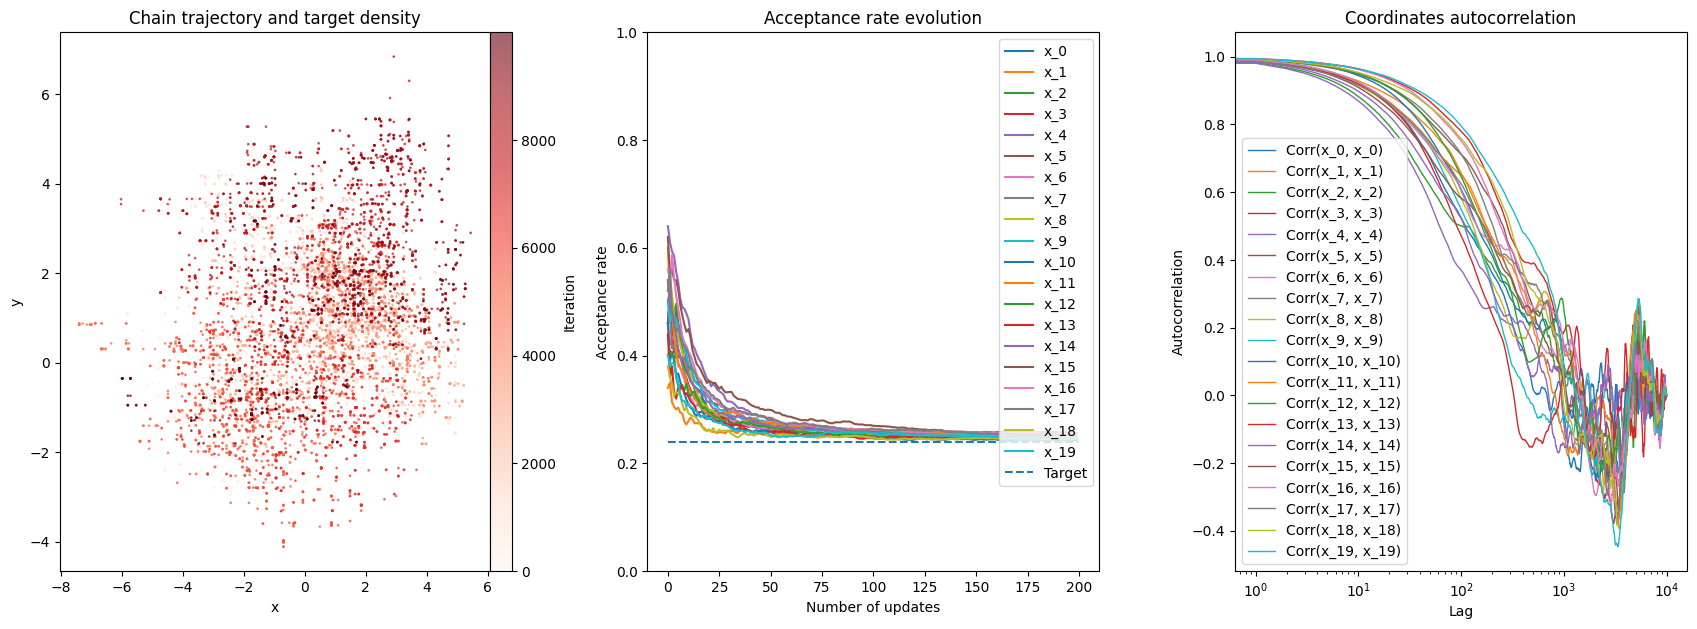

In [8]:
def log_pi(z):
    return (-1 / 2) * (z.T.dot(np.linalg.inv(sigma))).dot(z)


z_chain, acceptances = adaptative_metropolis_hastings_within_gibbs(
    np.random.rand(20),
    log_pi,
    iter=10000,
)

plot_adaptative_gibbs(
    z_chain,
    acceptances,
    log_pi,
    plots=["trajectory", "acceptance", "autocorrelation"],
)

In this case the coordinates of the gaussian are highly correlated (the covariance matrix is far from being diagonal) so the shape of the autocorrelation is not surprising. The acceptance rates converge pretty fast with the suggested $\delta_j$. The first two coordinates that we plotted seem pretty uniformly distributed (given the high correlation between the coordinates).

#### Test on a banana

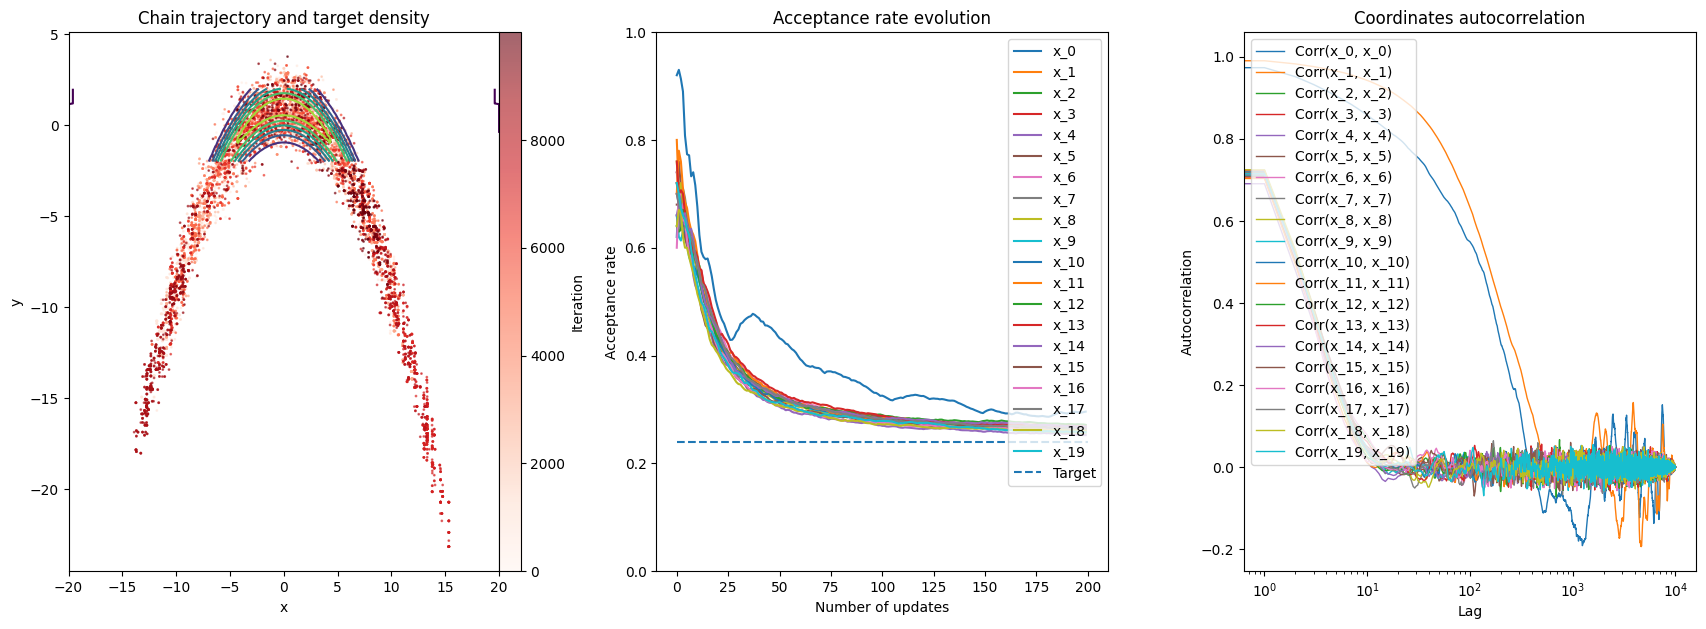

In [9]:
def log_pi(z):
    return (
        -z[0] ** 2 / 200
        - 1 / 2 * (z[1] + 0.1 * z[0] ** 2 - 1) ** 2
        - 1 / 2 * np.sum(z[2:] ** 2)
    )


z_chain, acceptances = adaptative_metropolis_hastings_within_gibbs(
    np.random.rand(20),
    log_pi,
    iter=10000,
)

plot_adaptative_gibbs(
    z_chain,
    acceptances,
    log_pi,
    plots=["trajectory", "density", "acceptance", "autocorrelation"],
)

This case is a great example of the power of adaptative metropolis-hastings. The banana is a highly anisotropic distribution, so the standard metropolis-hastings algorithm would have a hard time exploring the distribution (as we have seen in previous labs). However with adaptative metropolis-hastings, the chain is able to explore the distribution very well. Since it is very anisotropic, the chain will move slowly from one region to another, which is why if we run a limited number of iterations, we may only explore one side of the banana.

## Exercise 2: Sampling from multimodal distributions

Useful functions to plot gaussian mixture models.

In [10]:
n_ellipses = 3
cnorm = mcol.Normalize(vmin=1, vmax=n_ellipses)
cpick = cm.ScalarMappable(norm=cnorm, cmap="viridis_r")
cpick.set_array([])


def draw_ellipse(position, covariance, ax=None):
    ax = ax or plt.gca()

    if covariance.shape == (2, 2):
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    for nsig in range(1, n_ellipses + 1):
        ax.add_patch(
            Ellipse(
                position,
                (2 / n_ellipses) * nsig * width,
                (2 / n_ellipses) * nsig * height,
                angle=angle,
                alpha=1,
                linewidth=0.5,
                edgecolor=cpick.to_rgba(nsig),
                fill=False,
            )
        )


def draw_gmm(ax, mus, sigma):
    for classe in range(len(mus)):
        draw_ellipse(
            (mus[classe, 0], mus[classe, 1]), sigma**2 * np.eye(len(mus[0])), ax=ax
        )


def draw_gmm_and_points(points, mus, sigma):
    _, ax = plt.subplots(1, 1, figsize=(7, 7))

    ax.scatter(points[:, 0], points[:, 1], s=1, label="Sampled points")
    draw_gmm(ax, mus, sigma)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Gaussian mixture density")
    plt.legend()
    plt.show()

### 2.A – A toy example

#### Question 1.

In [11]:
def symetric_random_walk_metropolis_hastings(z, pi, sigma=1, iter=DEFAULT_ITERATIONS):
    for _ in range(iter):
        proposal = np.random.multivariate_normal(z, sigma**2 * np.eye(len(z)))
        alpha = min(1, pi(proposal) / pi(z))

        if np.random.uniform() < alpha:
            z = proposal

    return z

#### Question 2.

In [12]:
sigma_i = 0.1
mus = np.array(
    [
        [
            2.18,
            5.76,
        ],
        [
            8.67,
            9.59,
        ],
        [
            4.24,
            8.48,
        ],
        [
            8.41,
            1.68,
        ],
        [
            3.93,
            8.82,
        ],
        [
            3.25,
            3.47,
        ],
        [
            1.70,
            0.50,
        ],
        [
            4.59,
            5.60,
        ],
        [
            6.91,
            5.81,
        ],
        [
            6.87,
            5.40,
        ],
        [
            5.41,
            2.65,
        ],
        [
            2.70,
            7.88,
        ],
        [
            4.98,
            3.70,
        ],
        [
            1.14,
            2.39,
        ],
        [
            8.33,
            9.50,
        ],
        [
            4.93,
            1.50,
        ],
        [
            1.83,
            0.09,
        ],
        [
            2.26,
            0.31,
        ],
        [
            5.54,
            6.86,
        ],
        [
            1.69,
            8.11,
        ],
    ]
)

In [13]:
def pi(z, T=1):
    return np.sum(
        0.05
        / np.sqrt(np.pi * 2 * sigma_i**2)
        * np.exp(
            -1
            / (2 * sigma_i**2)
            * ((z[0] - mus[:, 0]) ** 2 + (z[1] - mus[:, 1]) ** 2)
        )
    ) ** (1 / T)

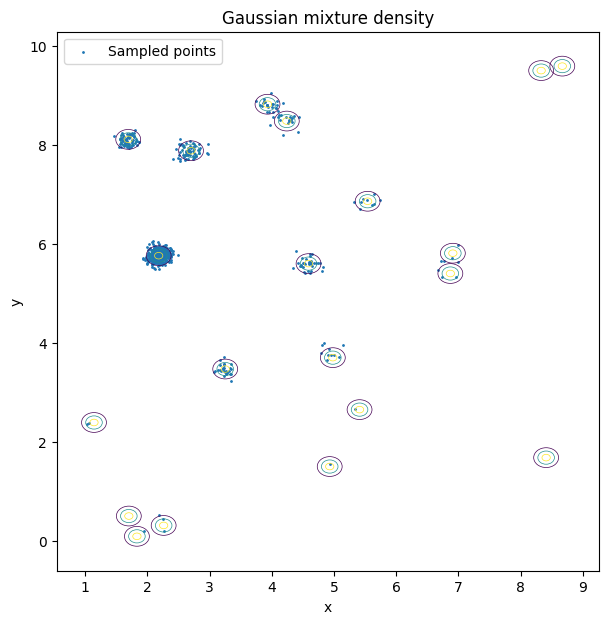

In [14]:
points = np.array(
    [symetric_random_walk_metropolis_hastings(mus[0], pi) for _ in range(1000)]
)

draw_gmm_and_points(points, mus, sigma_i)

The symmetric random walk metropolis hastings is able to explore a few modes of the distribution, but mainly remains stuck in the closest mode to the initial point.

In [15]:
def adaptative_symetric_random_walk_metropolis_hastings(
    z, pi, iter=DEFAULT_ITERATIONS, update=50
):
    z_chain = np.zeros((iter, len(z)))
    l = 0
    acceptances = np.zeros((iter // update))
    for j in range(iter // update):
        for k in range(update):
            proposal = np.random.normal(z, np.exp(l))
            alpha = min(1, pi(proposal) / pi(z))
            if np.random.uniform() < alpha:
                z = proposal
                acceptances[j] += 1

            z_chain[update * j + k] = z

        delta_j = min(0.01, 1 / np.sqrt(j + 1))
        update_direction = np.sign(acceptances[j] / update - 0.24)
        l += delta_j * update_direction
    return z_chain[-1]

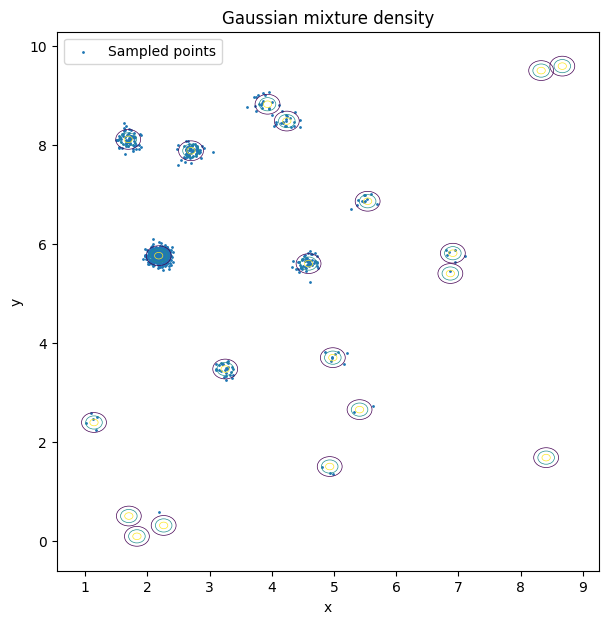

In [16]:
points = np.array(
    [
        adaptative_symetric_random_walk_metropolis_hastings(mus[0], pi)
        for _ in range(1000)
    ]
)

draw_gmm_and_points(points, mus, sigma_i)

Even the adaptative metropolis-hastings is not able to explore the distribution better. That's also expected since the gaussian proposal distribution cannot be tuned to explore one node (small variance) and find other nodes (big variance) at the same time.

### 2.B – Parallel Tempering

#### Question 1.

In [17]:
def parallel_tempering(z, pi, T, iter=DEFAULT_ITERATIONS):
    K = len(T)
    chains = np.zeros((iter + 1, K, len(z)))
    chains[0, :, :] = z[None, :]

    for n in range(1, iter + 1):
        for i in range(K):  # Update each chain
            tau = 1 * np.sqrt(
                T[i]
            )  # We took a factor of 1 instead of the suggested 0.25
            chains[n, i, :] = symetric_random_walk_metropolis_hastings(
                chains[n - 1, i, :], lambda z: pi(z, T=T[i]), sigma=tau
            )

        # Chains swap proposal
        i = np.random.randint(K - 1)
        j = i + 1
        alpha = min(
            1,
            pi(chains[n, j, :], T=T[i])
            * pi(chains[n, i, :], T=T[j])
            / (pi(chains[n, i, :], T=T[i]) * pi(chains[n, j, :], T=T[j])),
        )

        if np.random.uniform() < alpha:
            chains[n, i, :], chains[n, j, :] = chains[n, j, :], chains[n, i, :]

    return chains

#### Question 2.

In [18]:
T = np.array([60, 21.6, 7.7, 2.8, 1])

points = parallel_tempering(np.array([0, 0]), pi, T, iter=10000)

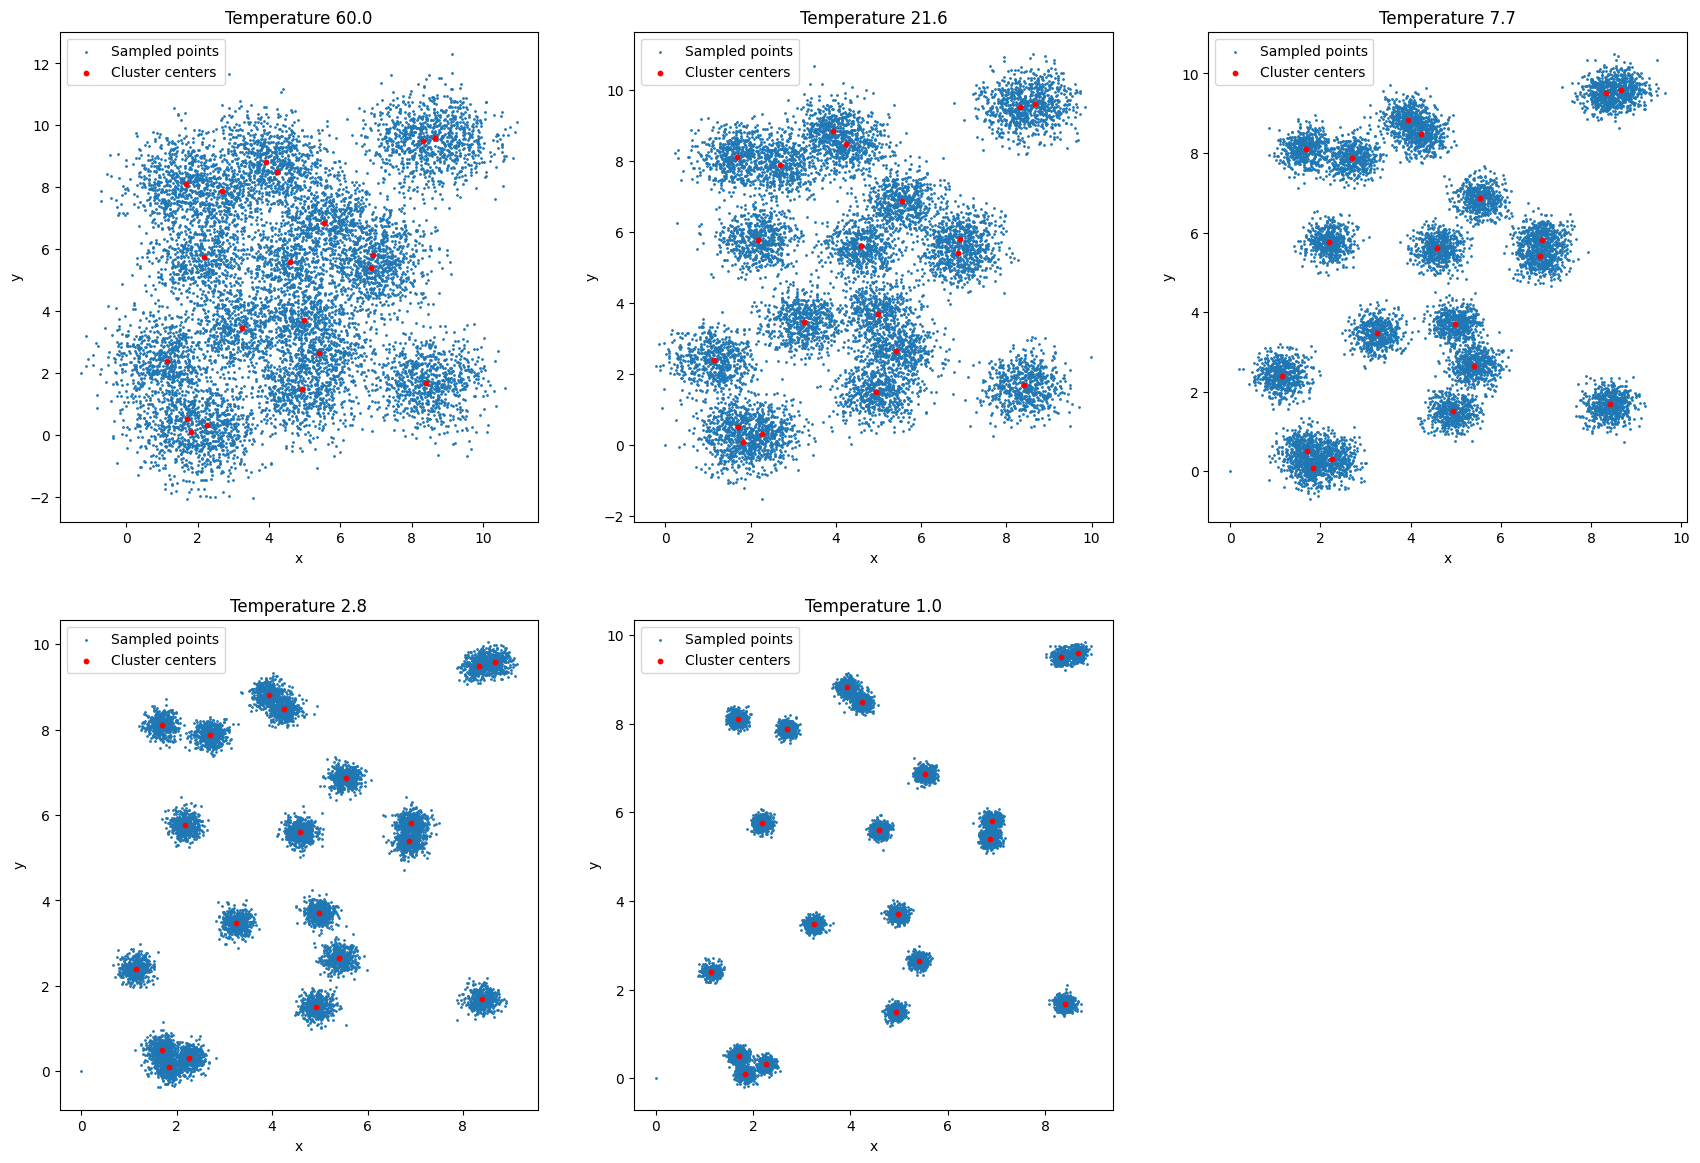

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(21, 14))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(T):
        break

    ax.scatter(points[:, i, 0], points[:, i, 1], s=1, label="Sampled points")
    ax.set_title(f"Temperature {T[i]}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.scatter(mus[:, 0], mus[:, 1], c="red", s=10, label="Cluster centers")

    ax.legend()

axes[-1].axis("off")
plt.show()

Tuning the hyperparameters for the parallel tempering may prove challenging. For some reason we ran into issues with the suggested $\tau_i=0.25\sqrt{T_i}$. We had to use $\tau_i=\sqrt{T_i}$ (greater proposal variance) to get good results.

## Exercise 3: Bayesian analysis of a one-way random effects model

Useful function to plot posterior distributions.

In [20]:
def plot_distribution(true_value, observed_values, variable_name, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(7, 7))

    ax.hist(observed_values, bins=50, density=True, label="Observed values")
    ax.axvline(true_value, color="red", label="True value")
    ax.set_xlabel(variable_name)
    ax.set_ylabel("Frequency")
    ax.set_title("Posterior distribution of " + variable_name)
    ax.legend()

#### Question 2.

In [21]:
def gibbs_sampler(
    X, mu, sigma, tau, Y, N, k, alpha, beta, gamma, iter=DEFAULT_ITERATIONS
):
    mu_list, sigma_list, tau_list = [], [], []
    for _ in range(iter):
        # The updates of each parameters correspond to the computations of the marginal distributions
        for i in range(N):
            X[i] = np.random.normal(
                loc=(sigma**2 * np.sum(Y[i, :]) + tau**2 * mu)
                / (np.count_nonzero(Y[i, :]) * sigma**2 + tau**2),
                scale=np.sqrt(
                    (sigma**2 * tau**2)
                    / (np.count_nonzero(Y[i, :]) * sigma**2 + tau**2)
                ),
            )
        mu = np.random.normal(loc=np.mean(X), scale=sigma / np.sqrt(N))
        sigma = np.sqrt(
            invgamma.rvs(N / 2 + alpha, scale=beta + 1 / 2 * np.sum((X - mu) ** 2))
        )
        tau = np.sqrt(
            invgamma.rvs(
                k / 2 + gamma, scale=beta + 1 / 2 * np.sum((X[:, None] - Y) ** 2)
            )
        )

        mu_list.append(mu)
        sigma_list.append(sigma)
        tau_list.append(tau)

    return X, mu_list, sigma_list, tau_list

#### Question 3.

In [22]:
def gibbs_block_sampler(
    X, mu, sigma, tau, Y, N, k, alpha, beta, gamma, iter=DEFAULT_ITERATIONS
):
    mu_list, sigma_list, tau_list = [], [], []
    for _ in range(iter):
        inverse_covariance_matrix = np.zeros((N + 1, N + 1))
        inverse_covariance_matrix[-1, :] = -1 / sigma**2
        inverse_covariance_matrix[:, -1] = -1 / sigma**2
        inverse_covariance_matrix[-1, -1] = N / sigma**2
        inverse_covariance_matrix[:-1, :-1] = np.diag(
            (np.count_nonzero(Y, axis=1) * sigma**2 + tau**2)
            / (sigma**2 * tau**2)
        )
        mean = np.zeros((N + 1))
        mean[:-1] = np.sum(Y, axis=1) / tau**2
        X_and_mu = multivariate_normal.rvs(
            mean=mean, cov=Covariance.from_precision(inverse_covariance_matrix)
        )[0]
        X = X_and_mu[:-1]
        mu = X_and_mu[-1]
        sigma = np.sqrt(
            invgamma.rvs(N / 2 + alpha, scale=beta + 1 / 2 * np.sum((X - mu) ** 2))
        )
        tau = np.sqrt(
            invgamma.rvs(
                k / 2 + gamma, scale=beta + 1 / 2 * np.sum((X[:, None] - Y) ** 2)
            )
        )

        mu_list.append(mu)
        sigma_list.append(sigma)
        tau_list.append(tau)

    return X, mu_list, sigma_list, tau_list

#### Question 5.

In [23]:
def generate_dataset(alpha, beta, gamma, mu, N, kmin=5, kmax=20):
    k = np.random.randint(kmin, kmax + 1, size=N)
    sigma = np.sqrt(invgamma.rvs(a=alpha, scale=beta))
    tau = np.sqrt(invgamma.rvs(a=gamma, scale=beta))
    X = np.random.normal(loc=mu, scale=sigma, size=(N))
    Y = np.zeros((N, kmax))
    for i in range(N):
        Y[i, : k[i]] = np.random.normal(loc=X[i], scale=tau, size=k[i])

    return X, mu, sigma, tau, Y, N, np.sum(k)

In [24]:
alpha, beta, gamma, mu = 1, 1, 1, 0
N = 1000
X, mu, sigma, tau, Y, N, k = generate_dataset(alpha, beta, gamma, mu, N)

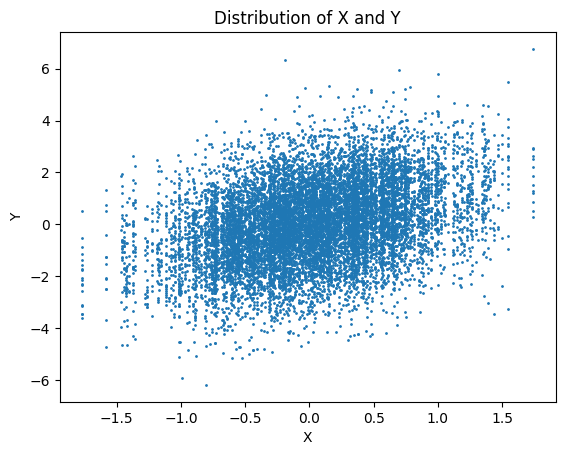

In [25]:
plt.scatter(X[:, np.newaxis].repeat(Y.shape[1], axis=1)[Y != 0], Y[Y != 0], s=1)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of X and Y")
plt.show()

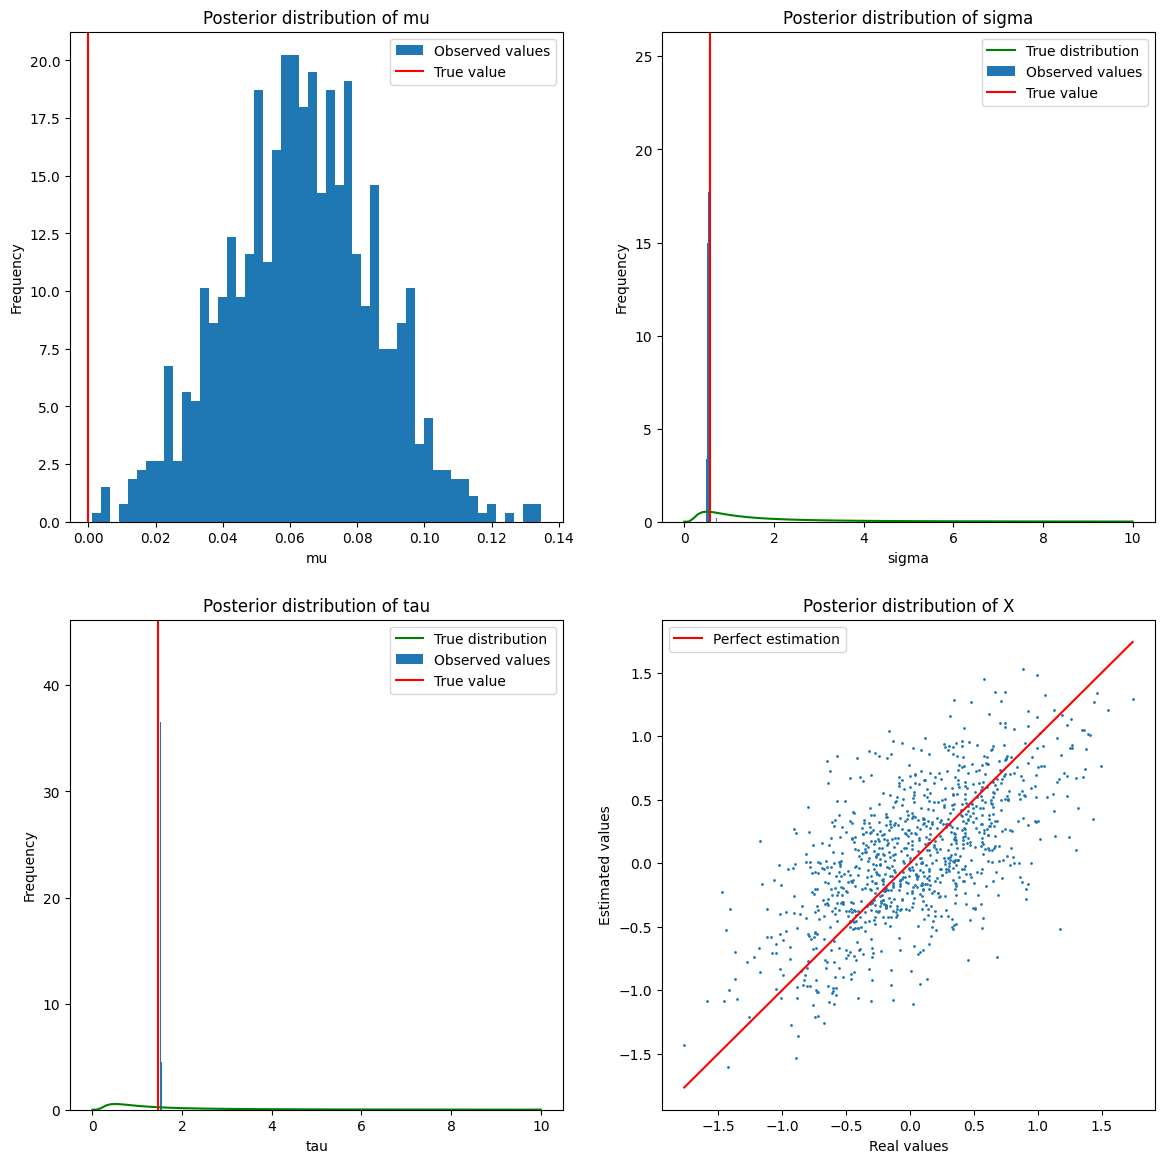

In [26]:
estimated_X, mus, sigmas, taus = gibbs_sampler(
    X=np.zeros(N),
    mu=0,
    sigma=1,
    tau=1,
    Y=Y,
    N=N,
    k=k,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    iter=1000,
)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 1].plot(
    np.linspace(0, 10, 100),
    invgamma.pdf(np.linspace(0, 10, 100), a=alpha, scale=beta),
    c="green",
    label="True distribution",
)
axes[1, 0].plot(
    np.linspace(0, 10, 100),
    invgamma.pdf(np.linspace(0, 10, 100), a=gamma, scale=beta),
    c="green",
    label="True distribution",
)

plot_distribution(mu, mus, "mu", ax=axes[0, 0])
plot_distribution(sigma, sigmas, "sigma", ax=axes[0, 1])
plot_distribution(tau, taus, "tau", ax=axes[1, 0])

axes[1, 1].scatter(X, estimated_X, s=1)
axes[1, 1].set_xlabel("Real values")
axes[1, 1].set_ylabel("Estimated values")
axes[1, 1].plot(
    [np.min(X), np.max(X)], [np.min(X), np.max(X)], c="red", label="Perfect estimation"
)
axes[1, 1].set_title("Posterior distribution of X")
axes[1, 1].legend()
plt.show()

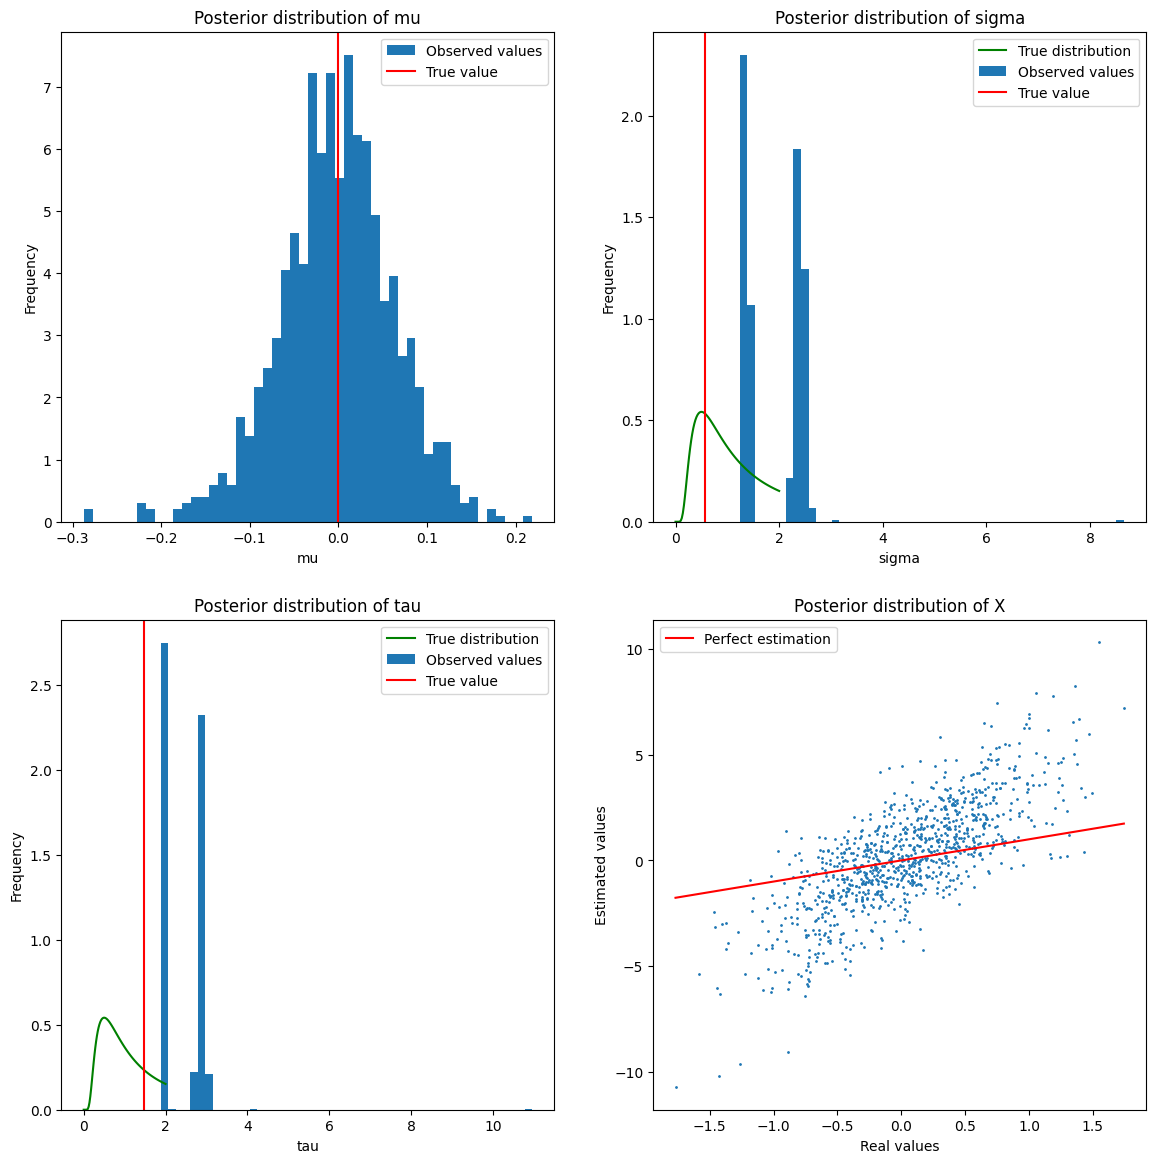

In [30]:
estimated_X, mus, sigmas, taus = gibbs_block_sampler(
    X=np.zeros(N),
    mu=0,
    sigma=1,
    tau=1,
    Y=Y,
    N=N,
    k=k,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    iter=1000,
)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 1].plot(
    np.linspace(0, 2, 100),
    invgamma.pdf(np.linspace(0, 2, 100), a=alpha, scale=beta),
    c="green",
    label="True distribution",
)
axes[1, 0].plot(
    np.linspace(0, 2, 100),
    invgamma.pdf(np.linspace(0, 2, 100), a=gamma, scale=beta),
    c="green",
    label="True distribution",
)

plot_distribution(mu, mus, "mu", ax=axes[0, 0])
plot_distribution(sigma, sigmas, "sigma", ax=axes[0, 1])
plot_distribution(tau, taus, "tau", ax=axes[1, 0])

axes[1, 1].scatter(X, estimated_X, s=1)
axes[1, 1].set_xlabel("Real values")
axes[1, 1].set_ylabel("Estimated values")
axes[1, 1].plot(
    [np.min(X), np.max(X)], [np.min(X), np.max(X)], c="red", label="Perfect estimation"
)
axes[1, 1].set_title("Posterior distribution of X")
axes[1, 1].legend()
plt.show()

In practice, we observe that block Gibbs sampling is quite slow, which can be explained by the difficulty of drawing random variables from a high-dimensional multivariate normal distribution. Let us note that we used the scipy sampler, which allows the use of the precision matrix $\Sigma^{-1}$, whereas with numpy, we would have had to invert this matrix at each iteration.

In terms of estimation performance, the block Gibbs sampler performs much better on the parameter $\mu$. However the it performs worse on the distributions of $\sigma$, $\tau$ and $X$ which is surprising.

For $X$, either we made a mistake in the computations or implementation of the marginal distribution of $X$, or the block for $X$ is too difficult to sample from (it is a high-dimensional multivariate normal distribution after all).

For $\sigma$ and $\tau$, this may be down to dumb luck as the classic gibbs sampler did not give a good posterior distribution, but it found the right mode for $\sigma$ and $\tau$. In some experiments we observed that the block gibbs sampler was able to better model the inverse gamma distribution of $\sigma$ and $\tau$.